In [1]:
from PIL import Image
import jax
from jax import random
import jax.numpy as jnp
import flaxmodels as fm
from torchvision import datasets, models, transforms
import torchvision
import torch
import matplotlib.pyplot as plt
from flax import traverse_util
import flax
import flax.linen as nn
from flax.core.frozen_dict import freeze
from optax import adamw
from flax.core.frozen_dict import FrozenDict
from flax.core import frozen_dict
import optax
import os

key = random.PRNGKey(0)

/opt/homebrew/Caskroom/miniforge/base/envs/ds/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load image
img = Image.open('data/n01440764_tench.JPEG')
# Image must be 224x224 if classification head is included
img = img.resize((224, 224))
# Image should be in range [0, 1]
x = jnp.array(img, dtype=jnp.float32) / 255.0
# Add batch dimension
x = jnp.expand_dims(x, axis=0)

In [3]:
x.shape

(1, 224, 224, 3)

In [4]:
resnet18 = fm.ResNet18(output='activations', pretrained='imagenet')
# params = vgg16.init(key, x)
# out = vgg16.apply(params, x, train=False)

In [5]:
vgg19 = fm.VGG19(output='activations', pretrained='imagenet')
params = vgg19.init(key, x, train=False)

Downloading: "https://www.dropbox.com/s/1sn02fnkj579u1w/vgg19_weights.h5" to /var/folders/_0/jg31z24j4s78_r7b93bhvd400000gn/T/flaxmodels/vgg19_weights.h5


 55%|█████▍    | 314M/575M [02:43<01:23, 3.13MiB/s]  

In [ ]:
rng_image = random.uniform(key, shape=(1, 224, 224, 3))

In [ ]:
# params = resnet18.init(key, rng_image)


In [ ]:
# out = resnet18.apply(params, rng_image, train=False)
out = vgg19.apply(params, rng_image, train=False)
out.keys()

dict_keys(['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'fc6', 'relu6', 'fc7', 'relu7', 'fc8'])

In [ ]:
out['fc8'].shape

(1, 1000)

In [ ]:
out['fc8'][0, 0]

DeviceArray(0.6761138, dtype=float32)

In [ ]:
out['conv5_2'][0, :, :, 0].shape

(14, 14)

In [ ]:
out['conv1'].shape

(1, 112, 112, 64)

In [ ]:
cnn_layer = 0
cnn_filter = 0

In [ ]:
out['block1_0'][0, :, :, 2].shape

(56, 56)

In [ ]:
out.keys()

dict_keys(['conv1', 'block1_0', 'block1_1', 'block2_0', 'block2_1', 'block3_0', 'block3_1', 'block4_0', 'block4_1', 'fc'])

In [ ]:
out['block1_0'].shape

(1, 56, 56, 64)

In [ ]:
jnp.mean(out['conv1'][0, :, :, 0])  

DeviceArray(0.02512577, dtype=float32)

In [ ]:
def create_mask(params, label_fn):
    mask = {}

    def _map(params, mask, label_fn):
        for k in params:
            if not label_fn(k):
                mask[k] = False
            else:
                if isinstance(params[k], FrozenDict):
                    mask[k] = {}
                    _map(params[k], mask[k], label_fn)
                else:
                    mask[k] = True

    _map(params, mask, label_fn)
    return frozen_dict.freeze(mask)


def print_tree(d, depth, print_value=False):
    for k in d.keys():
        if isinstance(d[k], FrozenDict):
            print("  " * depth, k)
            print_tree(d[k], depth + 1, print_value)
        else:
            if print_value:
                print("  " * depth, k, d[k])
            else:
                print("  " * depth, k)


def compare_params(lhs, rhs, depth):
    for k in lhs.keys():
        if isinstance(lhs[k], FrozenDict):
            print("  " * depth, k)
            compare_params(lhs[k], rhs[k], depth + 1)
        else:
            print("  " * depth, k, jnp.mean(jnp.abs(lhs[k] - rhs[k])))


In [ ]:
def revert_image(image):
    image = image.squeeze(0)

    return image

In [ ]:
def save_image(img, path):
    """ Displays and saves the processsed image from the 
        given layer/filter number.
        Arguments:
            - image (np.ndarray)
            - path (string) save path
    """
    plt.figure(figsize=[2,2])
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout(pad=0.5, h_pad=0, w_pad=0)
    plt.savefig(path, dpi=150)
    plt.show()  

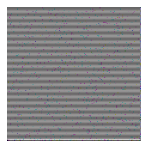

In [ ]:
r_image = revert_image(rng_image)
save_image(r_image, 'output/tmp.png')

In [ ]:
@jax.jit
def train_step(state, batch, layer_name, filter_num):
    def loss_fn(params):
        act = state.apply_fn({'params': params}, batch)
        act = act[layer_name][0, :, :, filter_num]

        loss = - jnp.mean(act)
        return loss

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

In [ ]:
im_params = {
    'params': rng_image.squeeze(0)
}

In [ ]:
class ImageLayer(nn.Module):
    @nn.compact
    def __call__(self, inputs):
        kernel = self.param("image", jax.nn.initializers.constant(1), (1, 224, 224, 3))
        return jax.lax.mul(inputs, kernel)


In [ ]:
class ModelWrapper(nn.Module):
    backbone: nn.Module

    @nn.compact
    def __call__(self, x):
        x = ImageLayer()(x)

        x = self.backbone(x, train=False)
        return x

In [ ]:
# model = Tmp(fm.ResNet18(output='activations', pretrained='imagenet'))
model = ModelWrapper(fm.VGG19(output='activations', pretrained='imagenet'))
variables = model.init(jax.random.PRNGKey(1), rng_image)
variables = variables.unfreeze()
variables['params']['backbone'] = params['params']
variables = freeze(variables)

In [ ]:
def create_mask():
    mask = {'params': {'ImageLayer_0': 'ImageLayer_0', 'backbone': 'backbone'}}
    return frozen_dict.freeze(mask)

def zero_grads():
    def init_fn(_): 
        return ()
    def update_fn(updates, state, params=None):
        return jax.tree_map(jnp.zeros_like, updates), ()
    return optax.GradientTransformation(init_fn, update_fn)

In [ ]:
@jax.jit
def train_step(params, img, layer_name, filter_num):
    def loss_fn(params):
        act = model.apply(params, img)
        if 'fc' in layer_name:
            act = act[layer_name][:, filter_num]
        else:
            act = act[layer_name][0, :, :, filter_num]

        loss = - jnp.mean(act)
        return loss

    loss_val, grad_val = jax.value_and_grad(loss_fn)(params)

    return loss_val, grad_val['params']['ImageLayer_0']['image']

step: 4 loss: -11.429861068725586
step: 9 loss: -37.96495819091797


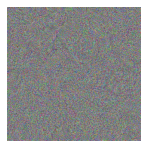

step: 14 loss: -76.7585220336914
step: 19 loss: -123.11090087890625


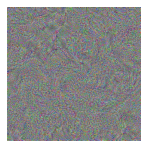

step: 24 loss: -181.21542358398438
step: 29 loss: -247.39964294433594


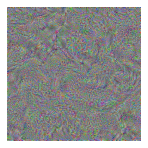

step: 34 loss: -319.41162109375


step: 39 loss: -391.8114929199219


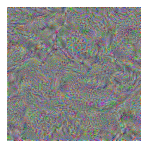

step: 44 loss: -465.7430725097656


step: 49 loss: -540.4721069335938


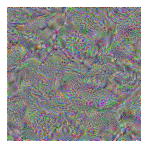

step: 54 loss: -614.7571411132812


step: 59 loss: -688.5842895507812


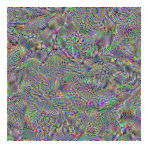

step: 64 loss: -761.5537719726562


step: 69 loss: -832.7269897460938


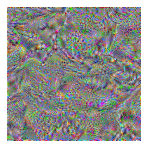

step: 74 loss: -904.3927001953125


step: 79 loss: -974.9540405273438


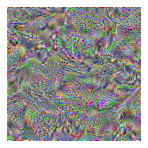

step: 84 loss: -1044.5523681640625


step: 89 loss: -1112.733642578125


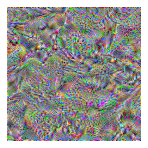

step: 94 loss: -1180.4720458984375


step: 99 loss: -1247.3309326171875


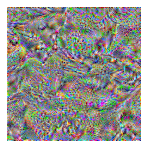

In [ ]:
layer_name = "fc7"
filter_num = "0"
model_name = "vgg16"

output_path = f"output/{model_name}/{layer_name}/{filter_num}"
os.makedirs(output_path, exist_ok=True)

steps = 100
lr = 0.01
optimizer = adamw(lr, weight_decay=1e-6)

rng_image = random.randint(key, shape=(1, 224, 224, 3), minval=83, maxval=171)
rng_image = rng_image.astype(jnp.float32)
rng_image = rng_image / 255

opt_state = optimizer.init({"params": rng_image})

for step in range(steps):
    loss, grad = train_step(variables, rng_image)
    updates, opt_state = optimizer.update(
        {"params": grad}, opt_state, {"params": rng_image}
    )
    rng_image = optax.apply_updates({"params": rng_image}, updates)
    rng_image = rng_image["params"]

    if (step + 1) % 5 == 0:
        print(f"step: {step} loss: {loss}")

    if (step + 1) % 10 == 0:
        r_image = revert_image(rng_image)
        save_image(r_image, f"{output_path}/{step}.png")
